In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from numpy import absolute
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder



# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense

import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from modules import transforms

### Data

In [2]:
sc = pd.read_csv("../../data/interim/UHistoric_Domestic.csv", index_col=False)
sc_n = pd.read_csv("../../data/processed/normalized_histdomestic.csv")
df_n =  pd.read_csv("../../data/processed/uslocs/normalized_usbanksincome.csv")
df = pd.read_csv("../../data/interim/US_Banks_Expense.csv", index_col=False)
cd = dict(zip(df.columns, df_n.columns))
df = df.rename(columns=cd)
cd = dict(zip(sc.columns, sc_n.columns))
sc = sc.rename(columns=cd)



### Preproc

In [3]:
targets_ppnr = {'Net interest income':'netIntInc', 'Total noninterest income':'nonIntInc',
                    'Total noninterest expense':'nonIntExp', 'Additional Noninterest Income':'addNonIntInc',
                    'Additional noninterest expense':'addNonIntExp'}
targets_ptni = {'Pre-tax net operating income': 'preTaxOperInc',
                        'Provision for loan and lease losses':'loanProvisions', 
                        'Net gains (losses) on sales of loans':'creditLosses', 
                        'Securities gains (losses)':'securityLosses',
                        'Net gains (losses) on sales of other assets (excluding securities)':'otherLosses'}
# print(df.shape)
# # change d2q
# cols = [col for col in df.columns]
# columns = cols[2:]    
# d2q = {col : transforms.date_to_qtr(col) for col in columns}
# df = df.rename(columns=d2q)
# print(df.shape)
# df = df.transpose()
# df.columns = df.iloc[0]
# df = df.iloc[1:, :] #setting column headers 
# print(df.shape)


In [4]:
# pred_df['addNonIntInc'] = pd.to_numeric(pred_df['addNonIntInc'])
# pred_df['addNonIntExp'] = pd.to_numeric(pred_df['addNonIntExp'])


In [5]:

def get_merged_reg(query, sc, df, deps):
    # sc = pd.read_csv("../../data/raw/dfast/Historic_Domestic.csv", index_col=False)
    # df = pd.read_csv("../../data/raw/uslocs/banks_income_expense_final.csv", index_col=False)

    # sc_n = pd.read_csv("../../data/processed/normalized_histdomestic.csv")
    # df_n =  pd.read_csv("../../data/processed/uslocs/normalized_usbanksincome.csv")

    # cd = dict(zip(df.columns, df_n.columns))
    # df = df.rename(columns=cd)
    # cd = dict(zip(sc.columns, sc_n.columns))
    # sc = sc.rename(columns=cd)


    #query 1 class Tag where query is string like : 'Total Assets:'
    r = df.query(f"Bank == {query}")
    # r.drop('Bank', axis=1, inplace=True) # cos why? They are all the same
    #Clean values
    r = r.fillna("$0")
    r.isnull().sum()
    #Transform dates
    cols = [col for col in r.columns]
    columns = cols[2:]    
    # for col in columns:
    #     # print(r[f'{col}'])
    #     r[f'{col}'] = r[f'{col}'].apply(lambda x : clean_vals(x))
    d2q = {col : transforms.date_to_qtr(col) for col in columns}
    n_df = r.rename(columns=d2q)
    # print(n_df.columns)
    

    #Transpose - to bank wise cols
    """Here, each bank col will become a dependent variable, so we will be predicting usng the 18 other 
    eco vars the tag(query) for each bank"""
    n_df = n_df.transpose()
    n_df.columns = n_df.iloc[0]
    ndf = n_df.iloc[2:, :] #setting column headers as bank names
    # this gives a data frame that has banks for columns and values for query with rows as quarters

    n_df = transforms.change_regressand_names(ndf, targets_ppnr)
    # print(n_df.columns)
    #get only regressands
    new_df = pd.DataFrame()
    for col in n_df.columns:
        if col in deps:
            reg = n_df[col]
            new_df.insert(new_df.shape[1], col, reg)

    n_df = new_df


    #map this to scenarios
    #I dont think the scenarios have the same number of years - they have more:')
    # inner join the 2 frames
    n_df['Date'] = n_df.index
    sc["Date"] = sc["Date"].astype(str)
    n_df["Date"] = n_df["Date"].astype(str)
    result = sc.merge(right=n_df, on="Date")
    
    return result #merged df


In [6]:
# query = "'netIntInc"
# r = df.query(f"Tag == {query}")

In [7]:
queries = df['Bank'].unique().tolist()
# queries = ['jpmorgan-chase-bank']# all banks
regs = [v for k, v in targets_ppnr.items()]
pred_df = pd.DataFrame()
for q in queries:
    q = f'"{q}"'
    blah = get_merged_reg(q, sc, df, regs)
    banks = [q for i in range(blah.shape[0])]
    blah.insert(2, "Bank", banks, allow_duplicates=True)
    date = blah["Date"].to_list()
    # data = blah.iloc[:,2:].astype('float32')
    data = blah.iloc[:,1:]
    data = transforms.change_names(data)
    # pred_df = data.iloc[:,:16]
    # pred_df = pd.concat([pred_df, data.iloc[:,-16:]], ignore_index=False, axis=1)
    # pred_df = pd.concat([pred_df, data.iloc[:,17:-16]], ignore_index=False, axis=1)
    pred_df = pd.concat([pred_df, data], ignore_index=True, axis=0)


#### Data Types

In [8]:
def lencode(pred_df):
    le1 = LabelEncoder()
    le2 = LabelEncoder() # not really necessary
    pred_df['Date'] = le1.fit_transform(pred_df['Date'])
    pred_df['Bank'] = le2.fit_transform(pred_df['Bank'])
    return pred_df
pred_df = lencode(pred_df)


In [9]:
pred_df.head(2)

,Date,Bank,realgdp,nomgdp,real_incgrowth,nom_incgrowth,unempr,cpiInflation,threemon,five,...,prime,djstock,houseprice,realEstate,market,netIntInc,nonIntInc,addNonIntInc,nonIntExp,addNonIntExp
0,0,10,5.6,7.9,2.8,5.2,6.6,3.4,3.1,5.0,...,6.0,4657.8,77.0,86.4,15.9,3706000000.0,2995000000.0,1544000000.0,4024000000.0,1473000000.0
1,1,10,4.7,7.0,5.9,7.9,5.6,2.3,5.3,7.6,...,8.1,4540.6,78.4,90.4,18.4,3779000000.0,2463000000.0,1627000000.0,4305000000.0,1695000000.0


In [10]:
cats = pred_df.iloc[:,:2]
pred_df = pred_df.iloc[:,2:].astype('float32')
pred_df = pd.concat([cats, pred_df], ignore_index=False, axis = 1)

In [11]:
pred_df.dtypes

Date                int32
Bank                int32
realgdp           float32
nomgdp            float32
real_incgrowth    float32
nom_incgrowth     float32
unempr            float32
cpiInflation      float32
threemon          float32
five              float32
ten               float32
corpyeild         float32
mortgage          float32
prime             float32
djstock           float32
houseprice        float32
realEstate        float32
market            float32
netIntInc         float32
nonIntInc         float32
addNonIntInc      float32
nonIntExp         float32
addNonIntExp      float32
dtype: object

## LR

In [12]:
scaler1 = MinMaxScaler()
norm_pred = scaler1.fit_transform(pred_df)
norm_df = pd.DataFrame(norm_pred, columns=pred_df.columns)

In [13]:
# regressors = ['Date','Bank','corpyeild', 'five', 'unempr', 'threemon', 'ten']
# #, 'market', 'realgdp'
# df = pd.DataFrame()
# for reg in regressors:
#     df.insert(df.shape[1], reg, pred_df[f'{reg}'], allow_duplicates=True)
# df.head()

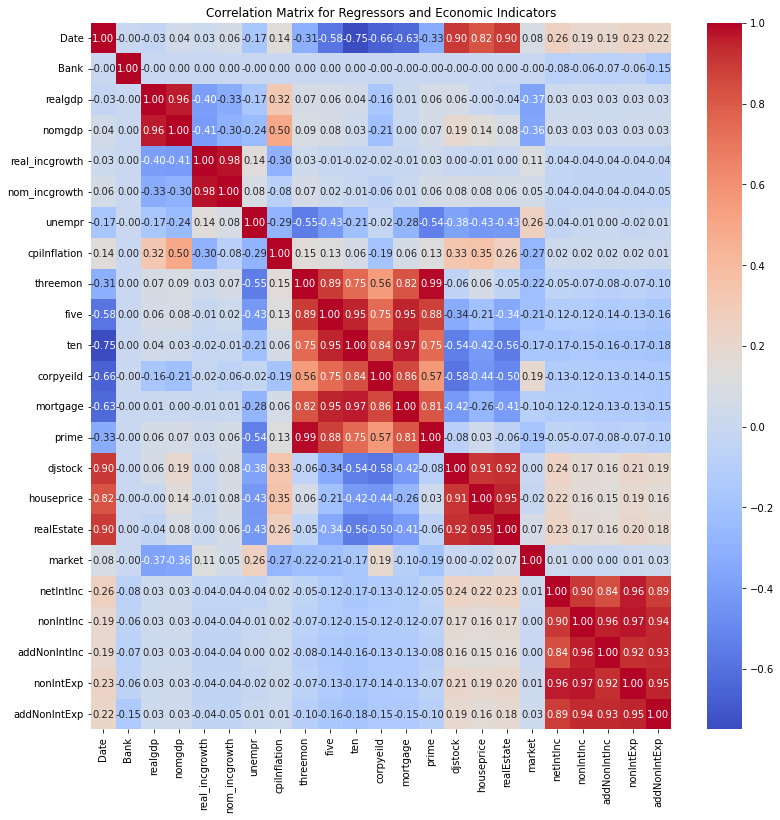

In [14]:
correlations = norm_df.corr()
plt.figure(figsize=(13, 13))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=True, yticklabels=True)
plt.title(f"Correlation Matrix for Regressors and Economic Indicators")

x_labels = correlations.columns

In [15]:
def reg_ip(topred):
    df = norm_df
    
    regressors = ['corpyeild', 'ten', 'unempr', 'market', 'realgdp']
    # creating feature variables 
    # X = df.iloc[:,:16]
    X = pd.DataFrame()
    cats = pred_df.iloc[:,:2]
    X = pd.concat([cats, X], ignore_index=False, axis = 1)
    for reg in regressors:
        X.insert(X.shape[1], reg, df[f'{reg}'], allow_duplicates=True)

    y = df[f'{topred}'] 

    # print(X) 
    # print(y) 

    # creating train and test sets 
    X_train, X_test, y_train, y_test = train_test_split( 
        X, y, test_size=0.3, random_state=101) 
    return X, y, X_train, X_test, y_train, y_test

#### Regressor - Regressand Plots

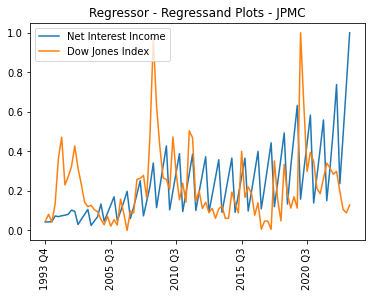

In [16]:
# plots for jpmc - 94 qtrs
plt.plot(norm_df["netIntInc"][:94], label="Net Interest Income")
# plt.plot(norm_df['corpyeild'][:94], label="BBB Corporate Yeild")
# plt.plot(norm_df['threemon'][:94], label="Three Month Treasury Rate")
# plt.plot(norm_df["unempr"][:94], label="Unemployment Rate")
plt.plot(norm_df['market'][:94], label="Dow Jones Index")
# plt.plot(norm_df['realgdp'][:94], label="Real GDP")
plt.legend()
plt.title("Regressor - Regressand Plots - JPMC")
x = [i for i in range(0, len(date), 20)]
labels = [date[i] for i in x]
plt.xticks(x, labels, rotation ='vertical') 
plt.show()


#### OLS

In [17]:
# def ols(target): # netIntInc, list
#     regrs = ['Date','Bank','corpyeild', 'threemon', 'unempr', 'market', 'realgdp']
#     X, y, X_train, X_test, y_train, y_test = reg_ip(target)
#     data = pd.concat([X_train, y_train], axis=1, ignore_index=False)
#     reg = "+".join(regrs)
#     model = smf.ols(f' {target} ~  {reg}', data=data).fit()
#     print(model.summary())
#     print("Parameters: ", model.params)
#     print("R2: ", model.rsquared)
    
#     # sns.mpl.rc("figure", figsize=(16, 10))

#     fig = sm.graphics.plot_ccpr_grid(model)
#     fig.tight_layout(pad=1.0)
#     fig = sm.graphics.plot_ccpr_grid(model)
#     fig.tight_layout(pad=1.0)

#     predictions = model.predict(X_test)
#     return model, predictions
# model, predictions = ols('netIntInc')

#### MLR

In [18]:
def mlr(topred):
    X, y, X_train, X_test, y_train, y_test = reg_ip(topred)
    # creating a regression model 
    # print(X_test)
    model = LinearRegression() 
    # fitting the model 
    model.fit(X_train, y_train) 

    # making predictions 
    predictions = model.predict(X_test) 

    # inverse transform
    colid = norm_df.columns.get_loc(topred)
    scale = MinMaxScaler()
    scale.min_, scale.scale_ = scaler1.min_[colid-2], scaler1.scale_[colid-2]
    y_arr = np.array(y_test).reshape(-1, 1)
    sev = scale.inverse_transform(y_arr)
    p_arr = np.array(predictions).reshape(-1, 1)
    sup = scale.inverse_transform(p_arr)

    # model evaluation 
    print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
    print('mean_absolute_error : ', mean_absolute_error(y_test, predictions)) 
    print('mean_absolute_%_error : ', mean_absolute_percentage_error(y_test, predictions)) 
    print('r2 score : ', r2_score(y_test, predictions)) 
    

    return model, predictions, y_test, mean_squared_error, mean_absolute_error
model, predictions, y_test, mse, mae = mlr('nonIntInc')

mean_squared_error :  0.01355092837200668
mean_absolute_error :  0.07288438109205606
mean_absolute_%_error :  1.2868463401134638
r2 score :  0.04768670203938452


#### Lasso

In [19]:
def lasso(topred):
    X, y, X_train, X_test, y_train, y_test = reg_ip(topred)
    model =  Lasso(alpha=0.1)
    
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    scores = absolute(scores)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test) 

    colid = norm_df.columns.get_loc(topred)
    scale = MinMaxScaler()
    scale.min_, scale.scale_ = scaler1.min_[colid-2], scaler1.scale_[colid-2]
    y_arr = np.array(y_test).reshape(-1, 1)
    sev = scale.inverse_transform(y_arr)
    p_arr = np.array(predictions).reshape(-1, 1)
    sup = scale.inverse_transform(p_arr)


    print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
    print('mean_absolute_error : ', mean_absolute_error(y_test, predictions)) 
    print('mean_absolute_%_error : ', mean_absolute_percentage_error(y_test, predictions)) 
    print('r2 score : ', r2_score(y_test, predictions)) 
    return model, predictions, y_test

model, predictions, y_test = lasso('nonIntInc')

Mean MAE: 0.074 (0.006)
mean_squared_error :  0.013666063862076578
mean_absolute_error :  0.07332057256729008
mean_absolute_%_error :  1.3119410310591815
r2 score :  0.039595370194750235


#### ElasticNet

In [20]:
def eNet(topred):
    X, y, X_train, X_test, y_train, y_test = reg_ip(topred)
    
    mod = ElasticNet(alpha=1.0, l1_ratio=0.5)

    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(mod, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    scores = absolute(scores)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

    
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test) 

    # inverse transform
    colid = norm_df.columns.get_loc(topred)
    scale = MinMaxScaler()
    scale.min_, scale.scale_ = scaler1.min_[colid-2], scaler1.scale_[colid-2]
    y_arr = np.array(y_test).reshape(-1, 1)
    sev = scale.inverse_transform(y_arr)
    p_arr = np.array(predictions).reshape(-1, 1)
    sup = scale.inverse_transform(p_arr)

    print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
    print('mean_absolute_error : ', mean_absolute_error(y_test, predictions)) 
    print('mean_absolute_%_error : ', mean_absolute_percentage_error(y_test, predictions)) 
    print('r2 score : ', r2_score(y_test, predictions)) 
    return mod, predictions, y_test

model, predictions, y_test = eNet('nonIntInc')

Mean MAE: 0.076 (0.006)
mean_squared_error :  0.014031491121279547
mean_absolute_error :  0.07492191207337956
mean_absolute_%_error :  1.3738948801103967
r2 score :  0.013914381496205719


#### RDF

In [21]:
def rdf(topred):
    X, y, X_train, X_test, y_train, y_test = reg_ip(topred)
    # print(X)
    regressor = RandomForestRegressor(n_estimators=4, random_state=0, oob_score=True)
    regressor.fit(X, y)
    predictions = regressor.predict(X_test)
    
    colid = norm_df.columns.get_loc(topred)
    scale = MinMaxScaler()
    scale.min_, scale.scale_ = scaler1.min_[colid-2], scaler1.scale_[colid-2]
    y_arr = np.array(y_test).reshape(-1, 1)
    sev = scale.inverse_transform(y_arr)
    p_arr = np.array(predictions).reshape(-1, 1)
    sup = scale.inverse_transform(p_arr)

    print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
    print('mean_absolute_error : ', mean_absolute_error(y_test, predictions)) 
    print('mean_absolute_%_error : ', mean_absolute_percentage_error(y_test, predictions)) 
    print('r2 score : ', r2_score(y_test, predictions)) 
    return regressor, predictions

model, predictions = rdf('nonIntInc')

mean_squared_error :  0.0011270158501642254
mean_absolute_error :  0.012309648078465161
mean_absolute_%_error :  0.11258059200284053
r2 score :  0.9207971474972201


c:\Users\18055\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


=========================================================================================================

#### Tests

In [22]:

colid = pred_df.columns.get_loc(f'nonIntInc')
scale = MinMaxScaler()
scale.min_, scale.scale_ = scaler1.min_[colid], scaler1.scale_[colid]

preds_arr = np.array(predictions).reshape(-1, 1)
preds = scale.inverse_transform(preds_arr)
ytest_arr = np.array(y_test).reshape(-1, 1)
ytest = scale.inverse_transform(ytest_arr)

preds = [x[0] for x in preds]
ytest = [x[0] for x in ytest]


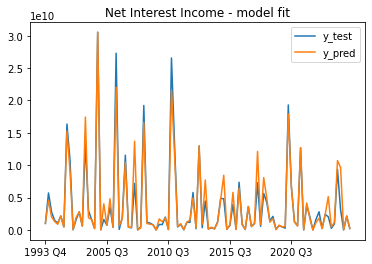

In [26]:
plt.plot(ytest[:100], label="y_test")
plt.plot(preds[:100], label="y_pred")
x = [i for i in range(0, len(date), 20)]
labels = [date[i] for i in x]
plt.xticks(x, labels) 
plt.legend()
plt.title("Net Interest Income - model fit")
plt.savefig("../../outputs/test_pred.png")
plt.show()


#### Scenarios

In [850]:
def pred_component(norm_df, target, regressors, bank): # netIntInc, list, bank on la
    
    # reg = "+".join(regressors)
    # model = smf.ols(f' {target} ~  {reg}', data=norm_df).fit()
    # print(model.summary())
    # print("Parameters: ", model.params)
    # print("R2: ", model.rsquared)

    # fig = sm.graphics.plot_ccpr_grid(model)
    # fig.tight_layout(pad=1.0)

    # model, predictions, y_test, mse, mae = mlr(target)
    # model, predictions, y_test = lasso(target)
    model, trash = rdf(target)
    
    severe = pd.read_csv('../../data/raw/dfast/Severe_Domestic.csv')
    supervisory = pd.read_csv('../../data/raw/dfast/Supervisory_Domestic.csv')

    banks = [bank for i in range(severe.shape[0])]

    severe.drop('Scenario Name', inplace=True, axis=1)
    severe.insert(1, "Bank", banks, allow_duplicates=True)
    
    severe_dates = severe['Date'].to_list()
    # print(severe.columns)
    pred_severe = severe

    cats = pred_severe.iloc[:,:2]
    le = LabelEncoder()
    cats["Date"] = le.fit_transform(cats["Date"])
    # cats  = lencode(cats)

    pred_severe = pred_severe.iloc[:,2:].astype('float32')

    scaler1 = MinMaxScaler()
    norm_pred = scaler1.fit_transform(pred_severe)
    norm_sev = pd.DataFrame(norm_pred, columns=pred_severe.columns)

    norm_sev = pd.concat([cats, norm_sev], ignore_index=False, axis = 1)
    
    norm_sev = transforms.change_names(norm_sev)



    # print(norm_sev.columns)
    norm_sev_X = pd.DataFrame()
    for reg in regressors:
        norm_sev_X.insert(norm_sev_X.shape[1], reg, norm_sev[f'{reg}'], allow_duplicates=True)
    # print(norm_sev_X)
    # norm_sev = add_lags(norm_sev)
    severe_predictions = model.predict(norm_sev_X)

    supervisory.drop('Scenario Name', inplace=True, axis=1)
    supervisory.insert(1, "Bank", banks, allow_duplicates=True)

    super_dates = supervisory['Date'].to_list()

    pred_super = supervisory
    cats = pred_super.iloc[:,:2]
    pred_super = pred_super.iloc[:,2:].astype('float32')
    pred_super = pd.concat([cats, pred_super], ignore_index=False, axis = 1)

    p_slice = pred_super.iloc[:,2:]
    scaler1 = MinMaxScaler()
    norm_pred = scaler1.fit_transform(p_slice)
    norm_super = pd.DataFrame(norm_pred, columns=pred_super.columns[2:])
    norm_super.insert(0, "Bank", pred_super["Bank"])
    norm_super.insert(0, "Date", pred_super["Date"])

    norm_super = transforms.change_names(norm_super)
    # norm_super = lencode(norm_super)
    le = LabelEncoder()
    norm_super["Date"] = le.fit_transform(norm_super["Date"])

    # norm_super = add_lags(norm_super)
    norm_sup_X = pd.DataFrame()
    for reg in regressors:
        norm_sup_X.insert(norm_sup_X.shape[1], reg, norm_super[f'{reg}'], allow_duplicates=True)
    # print(norm_sev_X, norm_sup_X)
    super_predictions = model.predict(norm_sup_X)
    return severe_predictions, super_predictions


In [851]:
# targets_ppnr = {'Net interest income':'netIntInc', 'Total noninterest income':'nonIntInc',
#                 'Total noninterest expense':'nonIntExp', 'Additional Noninterest Income':'addNonIntInc',
#                 'Additional noninterest expense':'addNonIntExp'}
# targets_ptni = {'Pre-tax net operating income': 'preTaxOperInc',
#                     'Provision for loan and lease losses':'loanProvisions', 
#                     'Net gains (losses) on sales of loans':'creditLosses', 
#                     'Securities gains (losses)':'securityLosses',
#                     'Net gains (losses) on sales of other assets (excluding securities)':'otherLosses'}
target_d = targets_ppnr # what d you want to predict
# pred_df = pred_df.rename(columns=target_d)
pred_df = pred_df.loc[:,~pred_df.columns.duplicated()].copy()
pred_df['addNonIntInc'] = pd.to_numeric(pred_df['addNonIntInc'])
pred_df['addNonIntExp'] = pd.to_numeric(pred_df['addNonIntExp'])

p_slice = pred_df.iloc[:,2:]
scaler1 = MinMaxScaler()
norm_pred = scaler1.fit_transform(p_slice)
norm_df = pd.DataFrame(norm_pred, columns=pred_df.columns[2:])
norm_df.insert(0, "Bank", pred_df["Bank"])
norm_df.insert(0, "Date", pred_df["Date"])

tars = [k for k, v in target_d.items()]
targets = [v for k, v in target_d.items()]

preds = []
for i in range(len(tars)):
    target = targets[i]
    tar = tars[i]
    # regressors = [ranks[tar][i][0] for i in range(5)]
    # regressors = ['djstock', 'corpyeild', 'ten']
    regressors = ['Date','Bank','corpyeild', 'ten', 'unempr', 'market', 'realgdp']
    sev, sup = pred_component(norm_df, target, regressors, 10) # 'jpmorgan-chase-bank'

    
    p_slice = pred_df.iloc[2:] # not working
    colid = p_slice.columns.get_loc(target)
    scale = MinMaxScaler()
    scale.min_, scale.scale_ = scaler1.min_[colid-2], scaler1.scale_[colid-2]

    sev_arr = np.array(sev).reshape(-1, 1)
    sev = scale.inverse_transform(sev_arr)
    sup_arr = np.array(sup).reshape(-1, 1)
    sup = scale.inverse_transform(sup_arr)

    preds.append((target, sev, sup))

# return preds, targets

c:\Users\18055\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\18055\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\18055\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\18055\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


mean_squared_error :  0.0008966405252615444
mean_absolute_error :  0.011466841116767292
mean_absolute_%_error :  91186523190.60767
r2 score :  0.918022429340161
mean_squared_error :  0.0010231327506398586
mean_absolute_error :  0.01202612065060751
mean_absolute_%_error :  0.11253030062928844
r2 score :  0.9280977014493568
mean_squared_error :  0.0012444202302256606
mean_absolute_error :  0.012304926498528577
mean_absolute_%_error :  25452298002.832947
r2 score :  0.919065553719772
mean_squared_error :  0.0018171347083308182
mean_absolute_error :  0.016240053234101482
mean_absolute_%_error :  0.1562439992122636
r2 score :  0.9147903309086914
mean_squared_error :  0.0018859797014963008
mean_absolute_error :  0.01684717986179327
mean_absolute_%_error :  0.1685525925023604
r2 score :  0.9096463760452476


c:\Users\18055\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [852]:
severe_ppnr = [preds[0][1][i] + preds[1][1][i] - preds[2][1][i] + preds[3][1][i] - preds[4][1][i] for i in range(13)]
super_ppnr = [preds[0][2][i] + preds[1][2][i] - preds[2][2][i] + preds[3][2][i] - preds[4][2][i] for i in range(13)]
# forget losses
# do loss with timeseries projections - supervisory tests are also stresses afterall
losses = [super_ppnr[i] - severe_ppnr[i] for i in range(len(super_ppnr))]
loss = 0
for l in losses[:]:
    # print(l)
    loss += l
loss/10**9 # for 12 quarters projected
# why is severe val higher than supervisory?
sum(severe_ppnr)/10**9 # projected ppnr for severe horizons

array([86.64924228])

In [853]:
loss
loss/sum(super_ppnr)
sum(super_ppnr)/10**9

array([105.20248763])

In [854]:
([x[0] for x in super_ppnr],[x[0] for x in severe_ppnr])

([-2327000258.8907685,
  1705750013.3441844,
  10845499489.591873,
  7847749161.835509,
  10454748701.323334,
  10343498805.70391,
  10904248689.468777,
  8821248911.036303,
  9451498833.956131,
  9451498833.956131,
  9451498833.956131,
  9451498833.956131,
  8800748781.850945],
 [3172250008.5466537,
  -8736250535.70362,
  -8598500461.013382,
  6977748649.647596,
  7171999192.647114,
  7060749297.027689,
  14431498770.212955,
  14066249777.070503,
  15071249463.37165,
  7985750062.581557,
  15182999671.786106,
  5830749245.168851,
  7032749139.864194])

In [855]:
a = np.array(preds[0][1])
a = [x[0] for x in a]
b = np.array(preds[1][1])
b = [x[0] for x in b]
c = np.array(preds[2][1])
c = [x[0] for x in c]
d = np.array(preds[3][1])
d = [x[0] for x in d]
e = np.array(preds[4][1])
e = [x[0] for x in e]
#super
a1 = np.array(preds[0][2])
a1 = [x[0] for x in a1]
b1 = np.array(preds[1][2])
b1 = [x[0] for x in b1]
c1 = np.array(preds[2][2])
c1 = [x[0] for x in c1]
d1 = np.array(preds[3][2])
d1 = [x[0] for x in d1]
e1 = np.array(preds[4][2])
e1 = [x[0] for x in e1]


### to_CSV

In [856]:
severe = pd.read_csv('../../data/raw/dfast/Severe_Domestic.csv')
sc_dates = severe["Date"].to_list()

In [857]:
ppnr_df = pd.read_csv('../../outputs/ppnr_1.csv')
ppnr_df = ppnr_df.drop("Unnamed: 0", axis=1)
ppnr_df.head()

,Date,netIntInc,nonIntInc,nonIntExp,addNonIntInc,addNonIntExp,ppnr
0,2023 Q4,93321000000,56906000000,78648000000,21079000000,21079000000,71579000000
1,2023 Q3,68735000000,45160000000,56267000000,17329000000,17329000000,57628000000
2,2023 Q2,44846000000,31269000000,37071000000,11569000000,11569000000,39044000000
3,2023 Q1,21820000000,14450000000,18108000000,3890000000,3890000000,18162000000
4,2022 Q4,68798000000,51370000000,68538000000,25954000000,25954000000,51630000000


In [858]:
temp = ppnr_df["netIntInc"].to_list()
netIntInc = [temp[n] for n in range(len(temp)-1, -1, -1)]
temp = ppnr_df["nonIntInc"].to_list()
nonIntInc = [temp[n] for n in range(len(temp)-1, -1, -1)]
temp = ppnr_df["nonIntExp"].to_list()
nonIntExp = [temp[n] for n in range(len(temp)-1, -1, -1)]
temp = ppnr_df["addNonIntInc"].to_list()
addNonIntInc = [temp[n] for n in range(len(temp)-1, -1, -1)]
temp = ppnr_df["addNonIntExp"].to_list()
addNonIntExp = [temp[n] for n in range(len(temp)-1, -1, -1)]
temp = ppnr_df["ppnr"].to_list()
ppnr_historic = [temp[n] for n in range(len(temp)-1, -1, -1)]
temp = ppnr_df["Date"].to_list()
Date = [temp[n] for n in range(len(temp)-1, -1, -1)]

In [859]:
sup_l = [i for i in ppnr_historic]
for i in super_ppnr:
    sup_l.append(int(i))
sev_l = [i for i in ppnr_historic]
for i in severe_ppnr:
    sev_l.append(int(i))
date_l = [i for i in Date]
for i in sc_dates:
    date_l.append(i)
    
a_l = [i for i in netIntInc]
for i in a:
    a_l.append(i)
b_l = [i for i in nonIntInc]
for i in b:
    b_l.append(i)
c_l = [i for i in nonIntExp]
for i in c:
    c_l.append(i)
d_l = [i for i in addNonIntInc]
for i in d:
    d_l.append(i)
e_l = [i for i in addNonIntExp]
for i in e:
    e_l.append(i)

al = [i for i in netIntInc]
for i in a1:
    al.append(int(i))
bl = [i for i in nonIntInc]
for i in b1:
    bl.append(int(i))
cl = [i for i in nonIntExp]
for i in c1:
    cl.append(int(i))
dl = [i for i in addNonIntInc]
for i in d1:
    dl.append(int(i))
el = [i for i in addNonIntExp]
for i in e1:
    el.append(int(i))

C:\Users\18055\AppData\Local\Temp\ipykernel_7988\555185163.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sup_l.append(int(i))
C:\Users\18055\AppData\Local\Temp\ipykernel_7988\555185163.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sev_l.append(int(i))


In [861]:
print(sum(sev_l[-12:])/10**9, sum(a_l[-12:])/10**9, sum(c_l[-12:])/10**9)


83.476992269 168.29499629973807 134.57375391902693


In [862]:
dfast = pd.DataFrame()
dfast.insert(dfast.shape[1], "Date", date_l, allow_duplicates=True)
dfast.insert(dfast.shape[1], "sev_netIntInc", a_l, allow_duplicates=True)
dfast.insert(dfast.shape[1], "sev_nonIntInc", b_l, allow_duplicates=True)
dfast.insert(dfast.shape[1], "sev_nonIntExp", c_l, allow_duplicates=True)
dfast.insert(dfast.shape[1], "sev_addNonIntInc", d_l, allow_duplicates=True)
dfast.insert(dfast.shape[1], "sev_addNonIntExp", e_l, allow_duplicates=True)

dfast.insert(dfast.shape[1], "sup_netIntInc", al, allow_duplicates=True)
dfast.insert(dfast.shape[1], "sup_nonIntInc", bl, allow_duplicates=True)
dfast.insert(dfast.shape[1], "sup_nonIntExp", cl, allow_duplicates=True)
dfast.insert(dfast.shape[1], "sup_addNonIntInc", dl, allow_duplicates=True)
dfast.insert(dfast.shape[1], "sup_addNonIntExp", el, allow_duplicates=True)


dfast.insert(dfast.shape[1], "severe_ppnr", sev_l, allow_duplicates=True)
dfast.insert(dfast.shape[1], "super_ppnr", sup_l, allow_duplicates=True)
dfast.to_csv("../../outputs/ppnr.csv")

#### Viz

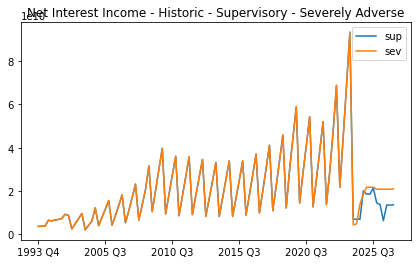

In [868]:
plt.figure(figsize=(7,4))
plt.plot(a_l, label = "sup")
plt.plot(al, label = "sev")
x = [i for i in range(0, len(date_l), 20)]
labels = [date_l[i] for i in x]
plt.xticks(x, labels) 
plt.legend()
plt.title("Net Interest Income - Historic - Supervisory - Severely Adverse")
# plt.savefig("../../outputs/nni_ss.png")
plt.show()


base  =  rdf<br>
<!-- rem corpyeild - array([63.97149997]), array([74.91374894]) (sev, sup), 9q - 48<br>
rem five - array([122.43074575]), array([97.65024468]), 80.02749733011277<br>


threemon - array([84.11624709]), array([89.11974779]), 78.1007476246736 - looks good!!, non-58, net-97<br>
ten - array([61.85824653]), array([69.70774384]), 47.70599603335585 - predictably worse<br>
threemon+corpyeild+.. - array([102.24299441]), array([99.20474447]), 76.96349623997119, nonintinc- 59/109 -->




> cos ppnr doesnt seem to be taking to short term dependecies very well - threemon, five







